In [59]:
import sys
import os
import numpy as np
import cv2
sys.path.append("./utils/") # Adds higher directory to python modules path.
import loadcoraldata_utils as coralutils
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from NeMO_losses import charbonnierLoss
import NeMO_layers
from keras.models import Model, Sequential, load_model
from scipy.misc import imresize
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from metrics import metrics

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%matplotlib notebook

model = load_model('./tmp/VGG16FCN_Kamlika400_RGB_NIR.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})
# SR_model = load_model('./tmp/SR_Kamalika_FeatureWise.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

In [60]:
# mat = np.load("test_train.npy")
# label = np.load("test_label.npy")
# trainX = mat['trainX']
# trainDX = mat['trainDX']
# trainY = mat['trainY']

img = coralutils.CoralData("../Images/Kamalika_Valid_Patches/Coral/Coral_00000000.tif", load_type="raster")
imgLR = coralutils.CoralData("../Images/Kamalika_ValidLR_Patches/Coral/Coral_00000000.tif", load_type="raster")
imglabel = cv2.imread("../Images/Kamalika_ValidRef_Patches/Coral/Coral_00000000.png",  cv2.IMREAD_GRAYSCALE)
imgLRlabel = cv2.imread("../Images/Kamalika_ValidLRRef_Patches/Coral/Coral_00000000.png",  cv2.IMREAD_GRAYSCALE)
img_Sentinel = coralutils.CoralData("../Images/Kamalika_Sentinel_Patches/Coral/Coral_00001000.tif", load_type="raster")

print(imgLRlabel.shape)

# Extra step for SR Featurewise model
# SR_model.summary()
# Input = SR_model.get_layer("model_1").get_input_at(0)
# SR_layer = SR_model.get_layer("model_1").get_output_at(0)

# print("Cut Model:")
# supermodel = Model(Input, SR_layer)
# supermodel.summary()


(80, 80)


<IPython.core.display.Javascript object>


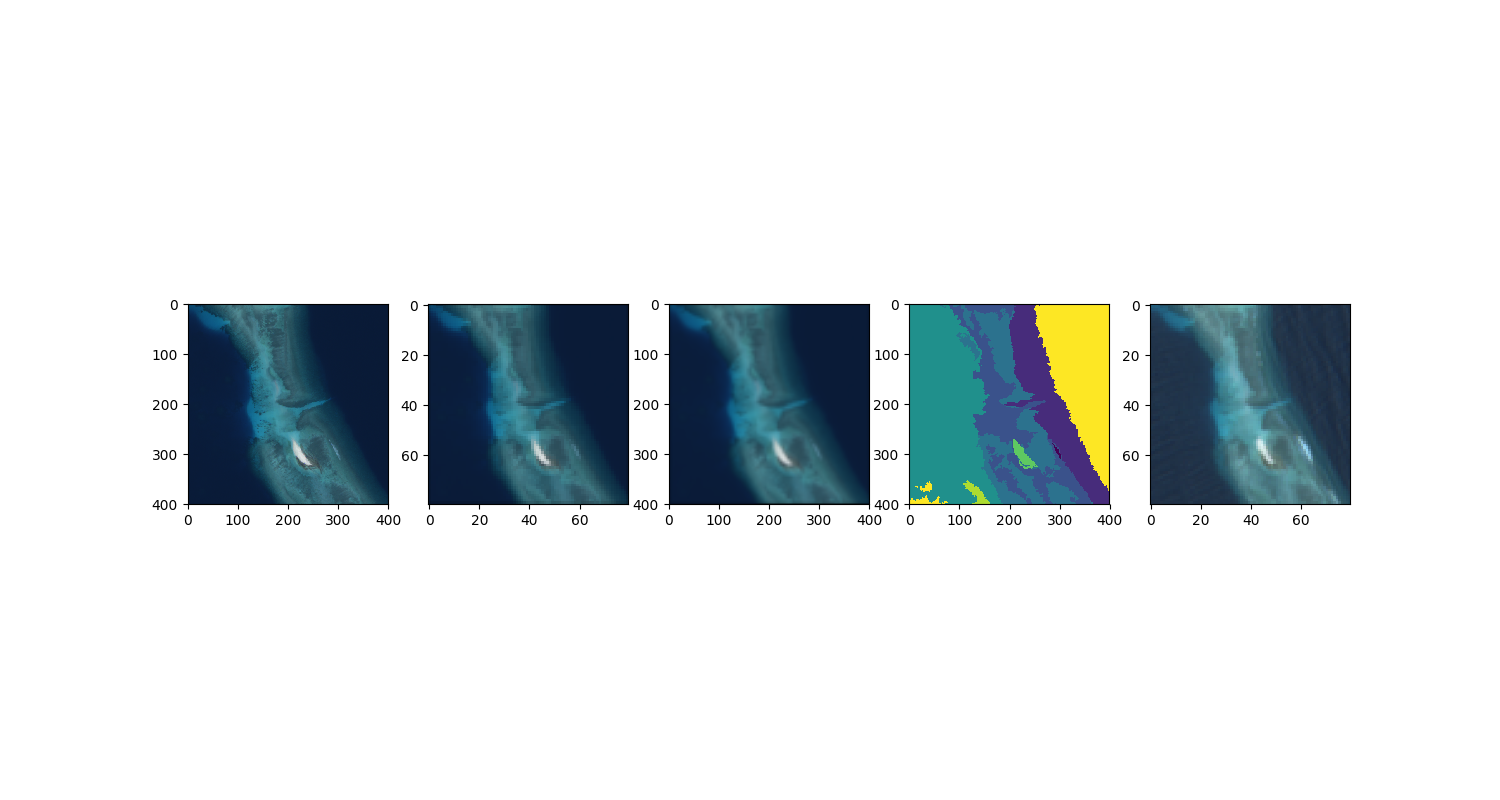

[11 35 63]
229


/home/asli/NeMO-Test/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/asli/NeMO-Test/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [61]:
def fixRGBimg(img,pixel_mean,pixel_std,minval,maxval):
    fixed_img = img
    fixed_img = fixed_img*pixel_std+pixel_mean
    fixed_img[fixed_img > maxval] = maxval
    fixed_img[fixed_img < minval] = minval
    fixed_img = np.asarray(fixed_img, dtype=np.uint8)
    return fixed_img

fig = plt.figure(1, figsize=(15,8))
ax = plt.subplot(151)
pic = np.rollaxis(np.asarray([img.image[:,:,0]*127.5+127.5, img.image[:,:,1]*127.5+127.5, img.image[:,:,2]*127.5+127.5]),0,3)
pic = np.asarray(pic, dtype=np.uint8)
ax.imshow(pic)
print(pic[100,100])

ax = plt.subplot(152)
pic = np.rollaxis(np.asarray([imgLR.image[:,:,0]*127.5+127.5, imgLR.image[:,:,1]*127.5+127.5, imgLR.image[:,:,2]*127.5+127.5]),0,3)
pic = np.asarray(pic, dtype=np.uint8)
ax.imshow(pic)

picresize = np.zeros(img.image.shape)
for i in range(0,pic.shape[2]):
    picresize[:,:,i] = rescale(imgLR.image[:,:,i]*127.5+127.5,5.0,anti_aliasing=False)
pic = np.rollaxis(np.asarray([picresize[:,:,0], picresize[:,:,1], picresize[:,:,2]]),0,3)
pic_LR = np.asarray(pic, dtype=np.uint8)
ax = plt.subplot(153)
ax.imshow(pic_LR)

ax = plt.subplot(154)
ax.imshow(imglabel)
print(np.max(imglabel))

# imgbatch = np.expand_dims(imgLR.image, axis=0)
# imgpredict = supermodel.predict(imgbatch, batch_size = 1)[0]
# kernel_sharpening = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# # imgpredict_sharpen = np.zeros(imgpredict.shape)
# # for i in range(4):
# #     imgpredict_sharpen[:,:,i] = cv2.filter2D(imgpredict[:,:,i], -1, kernel_sharpening)

# print(imgpredict)

ax = plt.subplot(155)
pic = np.rollaxis(np.asarray([img_Sentinel.image[:,:,0]*127.5+127.5, img_Sentinel.image[:,:,1]*127.5+127.5, img_Sentinel.image[:,:,2]*127.5+127.5]),0,3)
pic_Sentinel = np.asarray(pic, dtype=np.uint8)
ax.imshow(pic_Sentinel)

<IPython.core.display.Javascript object>


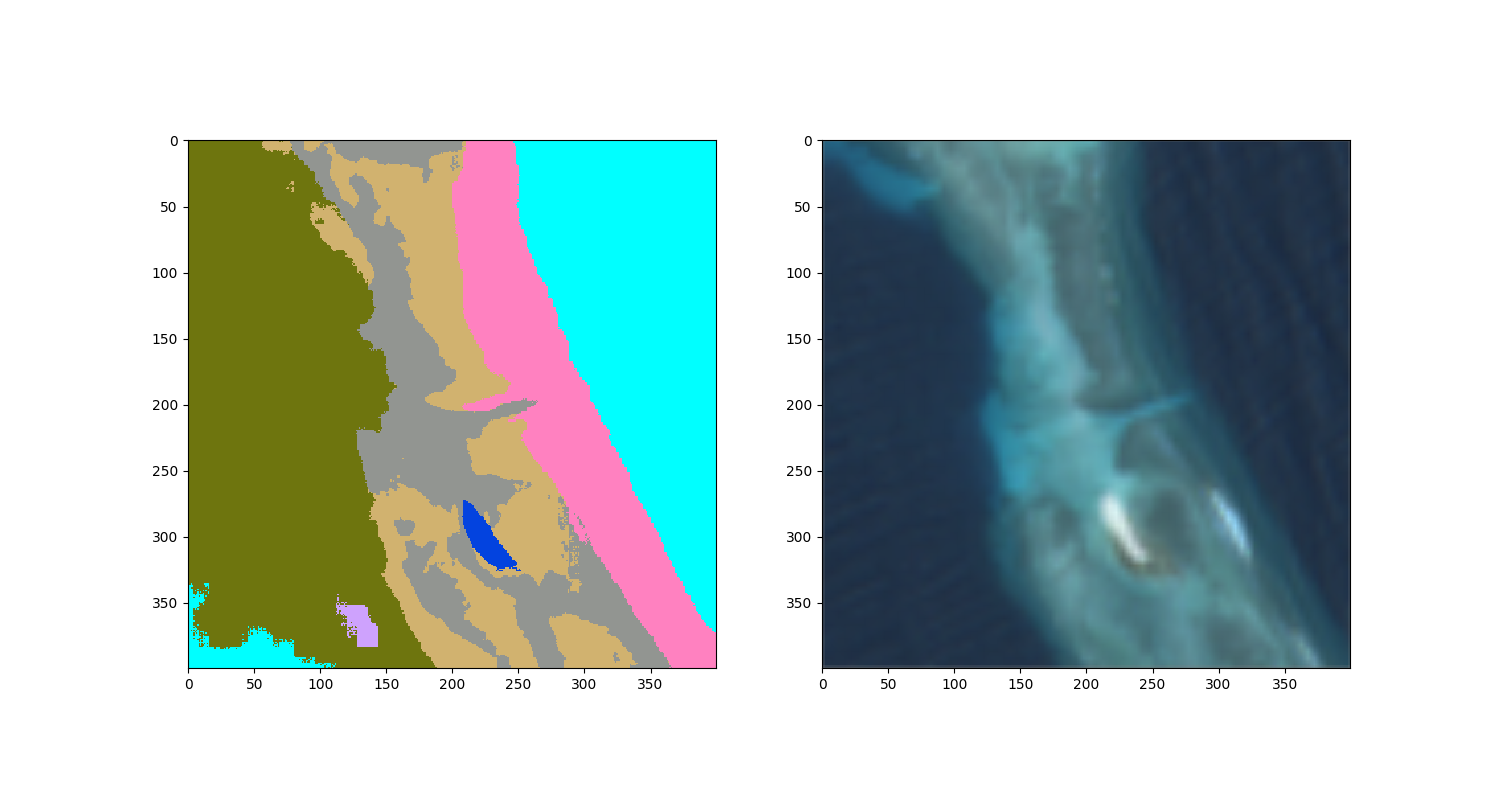

/home/asli/NeMO-Test/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/asli/NeMO-Test/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [71]:
def _classifyback(predictions):
    return np.argmax(predictions,-1)

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange', 'xkcd:white'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

img_batch = np.asarray([img.image],dtype=np.float32) 
modelpredict = model.predict_on_batch(img_batch)
modelpredict = _classifyback(modelpredict)
modelpredict = np.reshape(modelpredict, (400,400))

fig = plt.figure(2, figsize=(15,8))
ax = plt.subplot(121)
ax.imshow(modelpredict, interpolation='nearest', cmap=cmap_Ved, norm=norm)

img_Sentinel_upscale = np.zeros((400,400,4))
kernel_sharpening = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
for ch in range(0,4):
    img_Sentinel_upscale[:,:,ch] = rescale(img_Sentinel.image[:,:,ch],5,anti_aliasing=True)
#     img_Sentinel_upscale[:,:,ch] = cv2.filter2D(img_Sentinel_upscale[:,:,ch], -1, kernel_sharpening)

img_batch = np.asarray([img_Sentinel_upscale],dtype=np.float32)
modelpredict = model.predict_on_batch(img_batch)
modelpredict = _classifyback(modelpredict)
modelpredict = np.reshape(modelpredict, (400,400))

ax = plt.subplot(122)
# ax.imshow(modelpredict, interpolation='nearest', cmap=cmap_Ved, norm=norm)
pic = np.rollaxis(np.asarray([img_Sentinel_upscale[:,:,0]*127.5+127.5, img_Sentinel_upscale[:,:,1]*127.5+127.5, img_Sentinel_upscale[:,:,2]*127.5+127.5]),0,3)
pic_Sentinel = np.asarray(pic, dtype=np.uint8)
ax.imshow(pic_Sentinel)


In [73]:
CNN_predictions = []
CNN_labels = []
uniquelabels = [i*(255/10) for i in range(1,11)]
uniquelabels = np.asarray(uniquelabels, dtype=np.uint8)
print(uniquelabels)

num_images = 500

for i in range(0,num_images):
    filename = "Coral_" + str(i+1000).zfill(8) + '.tif'
    labelname = "Coral_" + str(i).zfill(8) + '.png'

    img = coralutils.CoralData("../Images/Kamalika_Sentinel_Patches/Coral/" + filename, load_type="raster")
    imglabel = cv2.imread("../Images/Kamalika_ValidRef_Patches/Coral/" + labelname,  cv2.IMREAD_GRAYSCALE)
    for labelidx in range(0,10):
        imglabel[imglabel == uniquelabels[labelidx]] = labelidx
    
    img_Sentinel_upscale = np.zeros((400,400,4))
    for ch in range(0,4):
        img_Sentinel_upscale[:,:,ch] = rescale(img_Sentinel.image[:,:,ch],5,anti_aliasing=True)
    
    img_batch = np.asarray([img_Sentinel_upscale],dtype=np.float32) 
    modelpredict = model.predict_on_batch(img_batch)
    modelpredict = _classifyback(modelpredict)
    CNN_predictions.append(modelpredict)
    CNN_labels.append(imglabel)
    
CNN_predictions = np.asarray(CNN_predictions)
CNN_predictions = np.reshape(CNN_predictions, (num_images,400,400,1))
CNN_labels = np.asarray(CNN_labels)
CNN_labels = np.reshape(CNN_labels,(num_images,400,400,1))
print(CNN_predictions.shape)
print(CNN_labels.shape)

metric = metrics(CNN_labels, CNN_predictions, classes=10)


[ 25  51  76 102 127 153 178 204 229 255]


/home/asli/NeMO-Test/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/asli/NeMO-Test/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(500, 400, 400, 1)
(500, 400, 400, 1)


In [74]:
label_accuracy = metric.label_accuracy()
confusionMatrix = metric.print_confusionMatrix()
intersect_of_union = metric.intersect_of_union()
probability_of_detection = metric.probability_of_detection()
false_alarm_ratio = metric.false_alarm_ratio()
critical_success_index = metric.critical_success_index()
rmse = metric.rmse()
precision = metric.precision()
f1_score = metric.f1_score()

print(label_accuracy)
print(intersect_of_union)
print(probability_of_detection)
print(false_alarm_ratio)
print(critical_success_index)
print(rmse)
print(precision)
print(f1_score)
print(confusionMatrix)

/home/asli/NeMO-Test/NeMO-NET/CNN/metrics.py:79: RuntimeWarning: invalid value encountered in double_scalars
  return [fpp * 1. / (tpp + fpp) for tpp, fpp in zip(tp, fp)]
/home/asli/NeMO-Test/NeMO-NET/CNN/metrics.py:107: RuntimeWarning: invalid value encountered in double_scalars
  return [tpp * 1. / (tpp + fpp) for tpp, fpp in zip(tp, fp)]


(0.09303449526170275, [0.0, 0.0016946322392840326, 0.20392102122417796, 0.5260495040964659, 0.0, 0.0001438709654814794, 0.12329283772358612, 0.0, 0.011024113873499084, 0.09447731495641629])
[0.         0.00167721 0.08047746 0.05993145 0.         0.00014358
 0.01049167 0.         0.01082063 0.01973298]
[0.0, 0.0016946322392840326, 0.20392102122417796, 0.5260495040964659, 0.0, 0.0001438709654814794, 0.12329283772358612, 0.0, 0.011024113873499084, 0.09447731495641629]
[nan, 0.8597622377622378, 0.8826563718231544, 0.9366477889491948, nan, 0.9343, 0.9886625104777871, nan, 0.6304317912218268, 0.9756643839919583]
[0.0, 0.001677207128138658, 0.08047746396893696, 0.05993144858501837, 0.0, 0.0001435772142742412, 0.010491669059180267, 0.0, 0.010820625519721438, 0.019732978440288266]
[3.6513267212069644, 3.6513267212069644, 3.6513267212069644, 3.6513267212069644, 3.6513267212069644, 3.6513267212069644, 3.6513267212069644, 3.6513267212069644, 3.6513267212069644, 3.6513267212069644]
[nan, 0.14023776

In [30]:
# img_train = coralutils.CoralData("./Generator_Outputs/valid_trainimg_0_3_105.tif", load_type="raster")
# img_trainHR = coralutils.CoralData("./Generator_Outputs/valid_trainimg_1_3_105.tif", load_type="raster")

# fig = plt.figure(10, figsize=(15,8))
# ax = plt.subplot(151)
# pic = np.rollaxis(np.asarray([img_train.image[:,:,0]*127.5+127.5, img_train.image[:,:,1]*127.5+127.5, img_train.image[:,:,2]*127.5+127.5]),0,3)
# pic = np.asarray(pic, dtype=np.uint8)
# ax.imshow(pic)

# ax = plt.subplot(152)
# pic = np.rollaxis(np.asarray([img_trainHR.image[:,:,0]*127.5+127.5, img_trainHR.image[:,:,1]*127.5+127.5, img_trainHR.image[:,:,2]*127.5+127.5]),0,3)
# pic = np.asarray(pic, dtype=np.uint8)
# ax.imshow(pic)

img = coralutils.CoralData("./Generator_Outputs/train_trainimg_1_0_603.tif", load_type="raster")
imgLR = coralutils.CoralData("./Generator_Outputs/train_trainimg_0_0_603.tif", load_type="raster")

temp = SR_model.predict([np.asarray([imgLR.image]), np.asarray([img.image])], batch_size=1)[0]
print(temp)
print(np.mean(np.sum(temp)))

[6.69034421e-01 1.71066418e-01 3.63215027e+01 6.34693742e-01
 1.91628411e-01 0.00000000e+00 8.04494381e-01 0.00000000e+00
 1.05025425e+01 1.27840722e+00 4.84821424e-02 8.81357133e-01
 1.41456203e+01 8.70329380e+00 4.91161489e+00 4.95684319e+01
 1.07713661e+01 2.16578484e-01 4.45886344e-01 2.98742962e+01
 4.44759369e+00 7.04892427e-02 8.78236961e+00 9.32331383e-01
 8.43888640e-01 3.15489769e-01 1.00986898e+00 8.33211169e-02
 1.09799966e-01 6.30456877e+00 7.78869214e-03 2.79003372e+01
 2.35568210e-01 7.59378958e+00 4.32243109e+00 1.61087322e+01
 1.62714176e+01 2.39141655e+01 0.00000000e+00 2.00484619e+01
 1.79344654e-01 3.57978523e-01 1.06993532e+00 4.01694832e+01
 1.71817407e-01 0.00000000e+00 2.07616978e+01 7.21686363e-01
 4.11362089e-02 1.34925652e+00 0.00000000e+00 1.43046573e-01
 0.00000000e+00 7.06214094e+00 9.69345868e-02 2.53249586e-01
 1.82048416e+01 6.34328842e-01 2.07309704e+01 2.98641658e+00
 1.45128136e+01 4.64510679e-01 3.39798443e-03 1.30751169e+00
 2.13440597e-01 0.000000